In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer

f:\UI\Semester 8\Tugas Akhir\topic-modelling\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_01 = pd.read_csv('data/stemmed_merged_kubu_01.csv')
df_01['created_at'] = pd.to_datetime(df_01['created_at'])
df_01['date'] = df_01['created_at'].dt.date


In [3]:
indo_stopwords = [
    # Basic Indonesian stopwords (keep these)
    "yang", "dan", "di", "dengan", "untuk", "dari", "ke", "pada", "ini", "itu",
    "atau", "ada", "juga", "dalam", "saya", "kamu", "anda", "mereka", "kita", "kami",
    "dia", "nya", "adalah", "akan", "oleh", "seperti", "telah", "sudah", "bisa", "dapat",
    "tidak", "tak", "jangan", "ya", "via", "yg", "dgn", "utk", "dr", "pd", "dlm", "sdh", "tdk",
    
    # All candidate names and variations (since they appear everywhere)
    "anies", "baswedan", "rasyid", "muhaimin", "iskandar", "cak", "imin", "gus", 
    "prabowo", "subianto", "gibran", "rakabuming", "raka", "ganjar", "pranowo", 
    "mahfud", "md", "gama", "mawi", "abdurrahman", "abdul", "amin"
    
    # Titles and name prefixes
    "mas", "pak", "bu", "bapak", "ibu", "om", "tante", "mbak", "bro", "sis", "bang", 
    "abang", "kak", "adek", "adik", "kakak", "bung", "prof", "dr", "haji", "hajah", "h",
    
    # Social media expressions
    "rt", "dm", "pm", "cc", "wkwk", "haha", "woi", "hey", "ah", "eh", "oh", "hmm", "btw",
    "omg", "lol", "sih", "aja", "gitu", "banget", "kok", "deh", "ih", "yuk", "mantap",
    "insya", "insyaallah", "alhamdulillah", "bismillah", "amin", "allahuma", "allah",
    
    # Locations
    "jakarta", "jawa", "barat", "timur", "tengah", "utara", "selatan", "sumatra", "bali", 
    "aceh", "kota", "desa", "daerah", "wilayah", "provinsi", "kabupaten", "kawasan",
    "bandung", "surabaya", "makassar", "balikpapan", "semarang", "yogyakarta", "solo",
    
    

]

In [4]:

vectorizer = CountVectorizer(
    stop_words=indo_stopwords,
    ngram_range=(1, 3),  # Keep bigrams and trigrams for political phrases
    min_df=5,            # Lower threshold to capture more specific topics
    max_df=0.7           # Stricter upper bound to remove very common terms
)

# Configure UMAP for better clustering of political content
umap_model = UMAP(
    n_neighbors=15,      # Smaller neighborhood for more specific clusters
    n_components=5,      
    min_dist=0.0,        # Adjusted for better separation
    metric='cosine',
    random_state=42
)

# More sensitive clustering for political topics
hdbscan_model = HDBSCAN(
    min_cluster_size=10,  # Smaller clusters to capture specific campaign themes
    min_samples=5,       # More lenient sample requirement
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

# Improved c-TF-IDF weighting
ctfidf_model = ClassTfidfTransformer(
    reduce_frequent_words=True,
    bm25_weighting=True
)

embedding_model = SentenceTransformer(
    'distiluse-base-multilingual-cased-v1'
)

# Configure BERTopic for Indonesian political content
topic_model = BERTopic(
    language="multilingual",  # Keep multilingual for Indonesian
    calculate_probabilities=True,
    verbose=True,
    nr_topics=15,             # Reduced from 15 to get more focused topics
    min_topic_size=10,         # Smaller topics to capture campaign themes
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    ctfidf_model=ctfidf_model,
    vectorizer_model=vectorizer,
    embedding_model=embedding_model,
)

timestamps = df_01['created_at'].tolist()

# Fit the model
topics, probs = topic_model.fit_transform(df_01['full_text'].tolist())

2025-05-24 19:43:10,886 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 934/934 [05:12<00:00,  2.99it/s]
2025-05-24 19:48:23,286 - BERTopic - Embedding - Completed ✓
2025-05-24 19:48:23,287 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-24 19:49:04,241 - BERTopic - Dimensionality - Completed ✓
2025-05-24 19:49:04,244 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-24 19:56:47,205 - BERTopic - Cluster - Completed ✓
2025-05-24 19:56:47,206 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-05-24 19:56:48,998 - BERTopic - Representation - Completed ✓
2025-05-24 19:56:48,999 - BERTopic - Topic reduction - Reducing number of topics
2025-05-24 19:56:49,136 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-24 19:56:50,144 - BERTopic - Representation - Completed ✓
2025-05-24 19:56:50,149 - BERTopic - Topic reduction - Re

In [5]:
# Generate more meaningful topic labels

# Create a topics over time analysis
topics_over_time = topic_model.topics_over_time(
    docs=df_01['full_text'].tolist(),
    timestamps=timestamps,
    global_tuning=True,
    evolution_tuning=True,
    nr_bins=14  # Roughly 1 bin per day for a two-week analysis
)

topic_labels = {}
for topic_id in topic_model.get_topic_info()["Topic"]:
    if topic_id == -1:
        topic_labels[topic_id] = "Outlier"
        continue
        
    # Get top words for the topic
    words = [word for word, _ in topic_model.get_topic(topic_id)[:5]]
    
    # Map topics to campaign themes based on keywords
    if any(term in words for term in ["palestina", "doa", "israel", "gaza"]):
        topic_labels[topic_id] = "Isu Palestina"
    elif any(term in words for term in ["aceh", "bandara", "kedatagan", "sambut"]):
        topic_labels[topic_id] = "Kampanye di Aceh"
    elif any(term in words for term in ["sumbar", "sumatra", "barat", "bukittinggi"]):
        topic_labels[topic_id] = "Kampanye Sumatra Barat"
    elif any(term in words for term in ["adil", "makmur", "sejahtera", "ekonomi"]):
        topic_labels[topic_id] = "Visi Ekonomi"
    elif any(term in words for term in ["islam", "muslim", "santri", "kiai"]):
        topic_labels[topic_id] = "Dukungan Religius"
    elif any(term in words for term in ["pesantren", "santri", "ulama"]):
        topic_labels[topic_id] = "Dukungan Pesantren"
    elif any(term in words for term in ["konstitusi", "mk", "etik"]):
        topic_labels[topic_id] = "Polemik MK"
    elif any(term in words for term in ["solo", "jakarta", "gubernur"]):
        topic_labels[topic_id] = "Kinerja Kepemimpinan"
    elif any(term in words for term in ["elektabilitas", "survei", "unggul"]):
        topic_labels[topic_id] = "Elektabilitas & Polling"
    elif any(term in words for term in ["debat", "pidato", "bicara"]):
        topic_labels[topic_id] = "Debat & Pidato"
    else:
        # Use top 3 words as label
        topic_labels[topic_id] = " & ".join(words[:3])

# Apply custom labels
topic_model.set_topic_labels(topic_labels)

topics_over_time["Name"] = topics_over_time["Topic"].map(
    lambda x: topic_model.get_topic_info().set_index("Topic").loc[x, "Name"]
    if x in topic_model.get_topic_info()["Topic"].values else f"Topic {x}")

14it [00:00, 15.23it/s]


In [6]:
from wordcloud import WordCloud
import seaborn as sns
# import mdates
import matplotlib.dates as mdates

<Figure size 2000x1000 with 0 Axes>

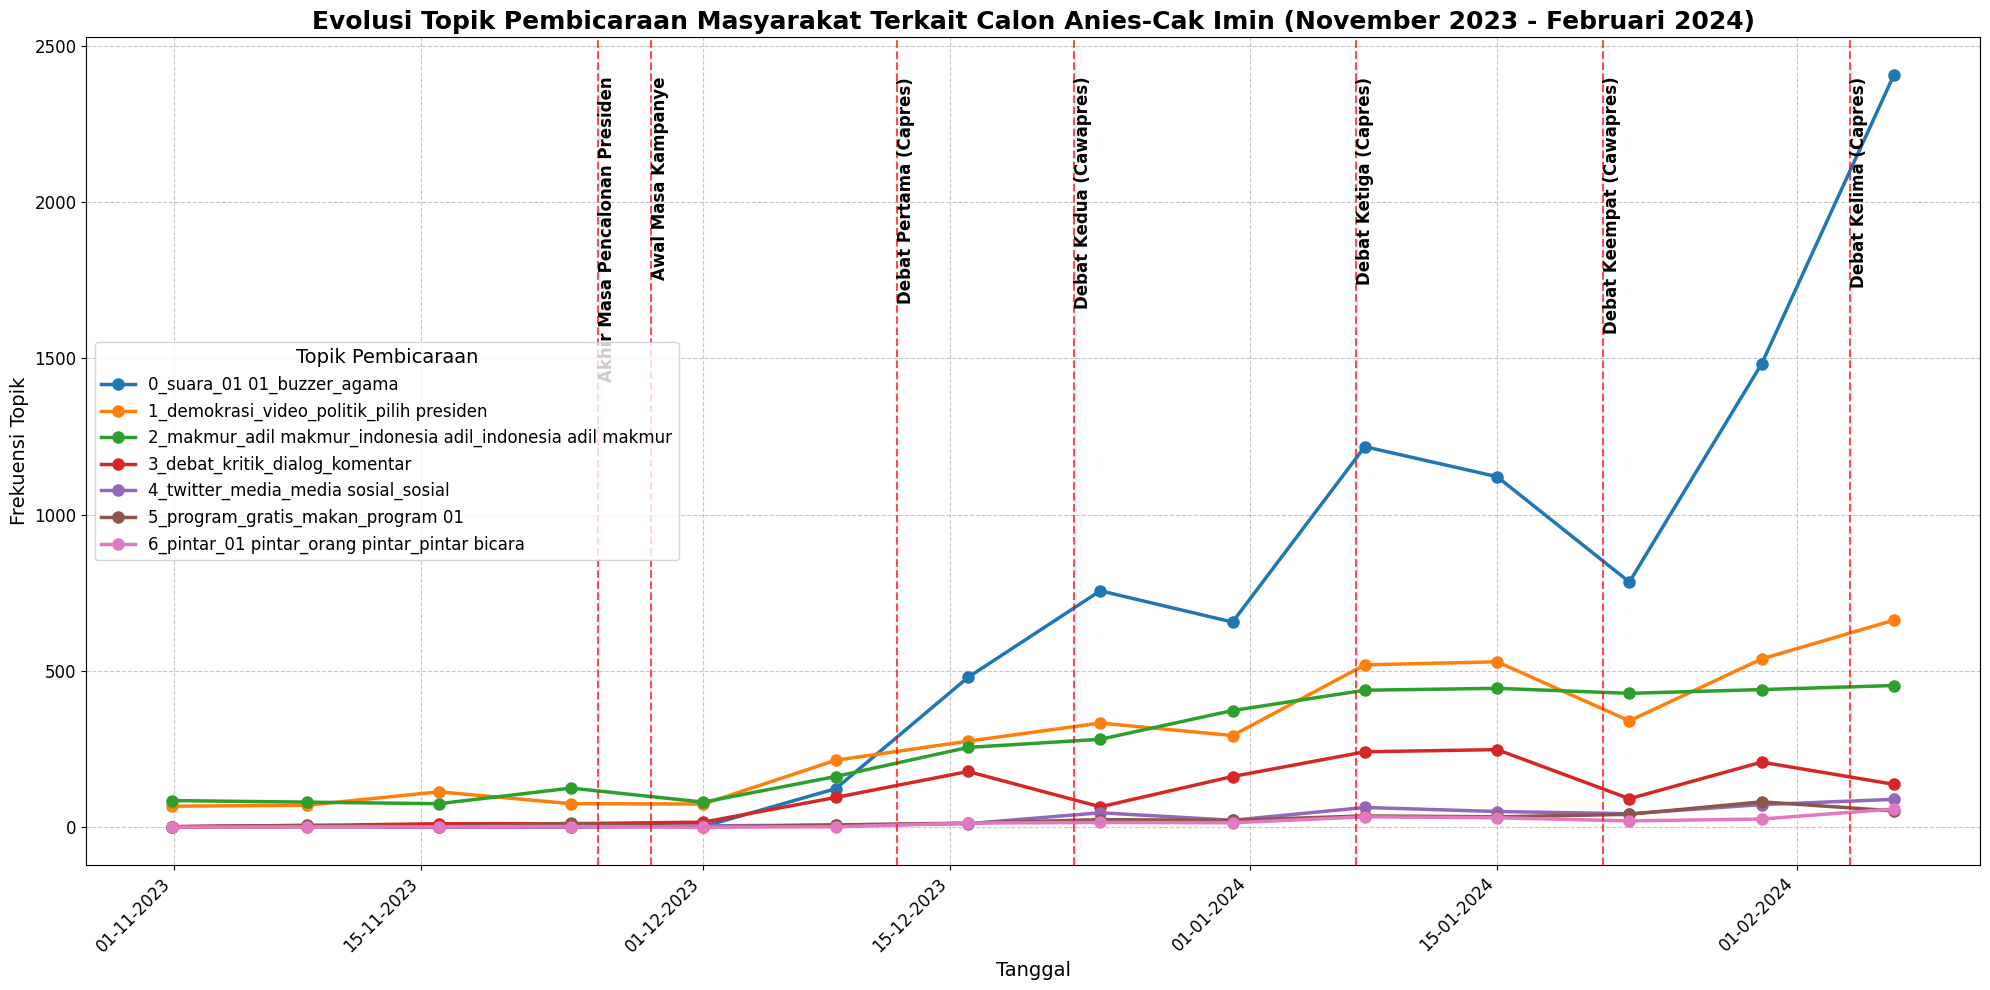

<Figure size 2000x1000 with 0 Axes>

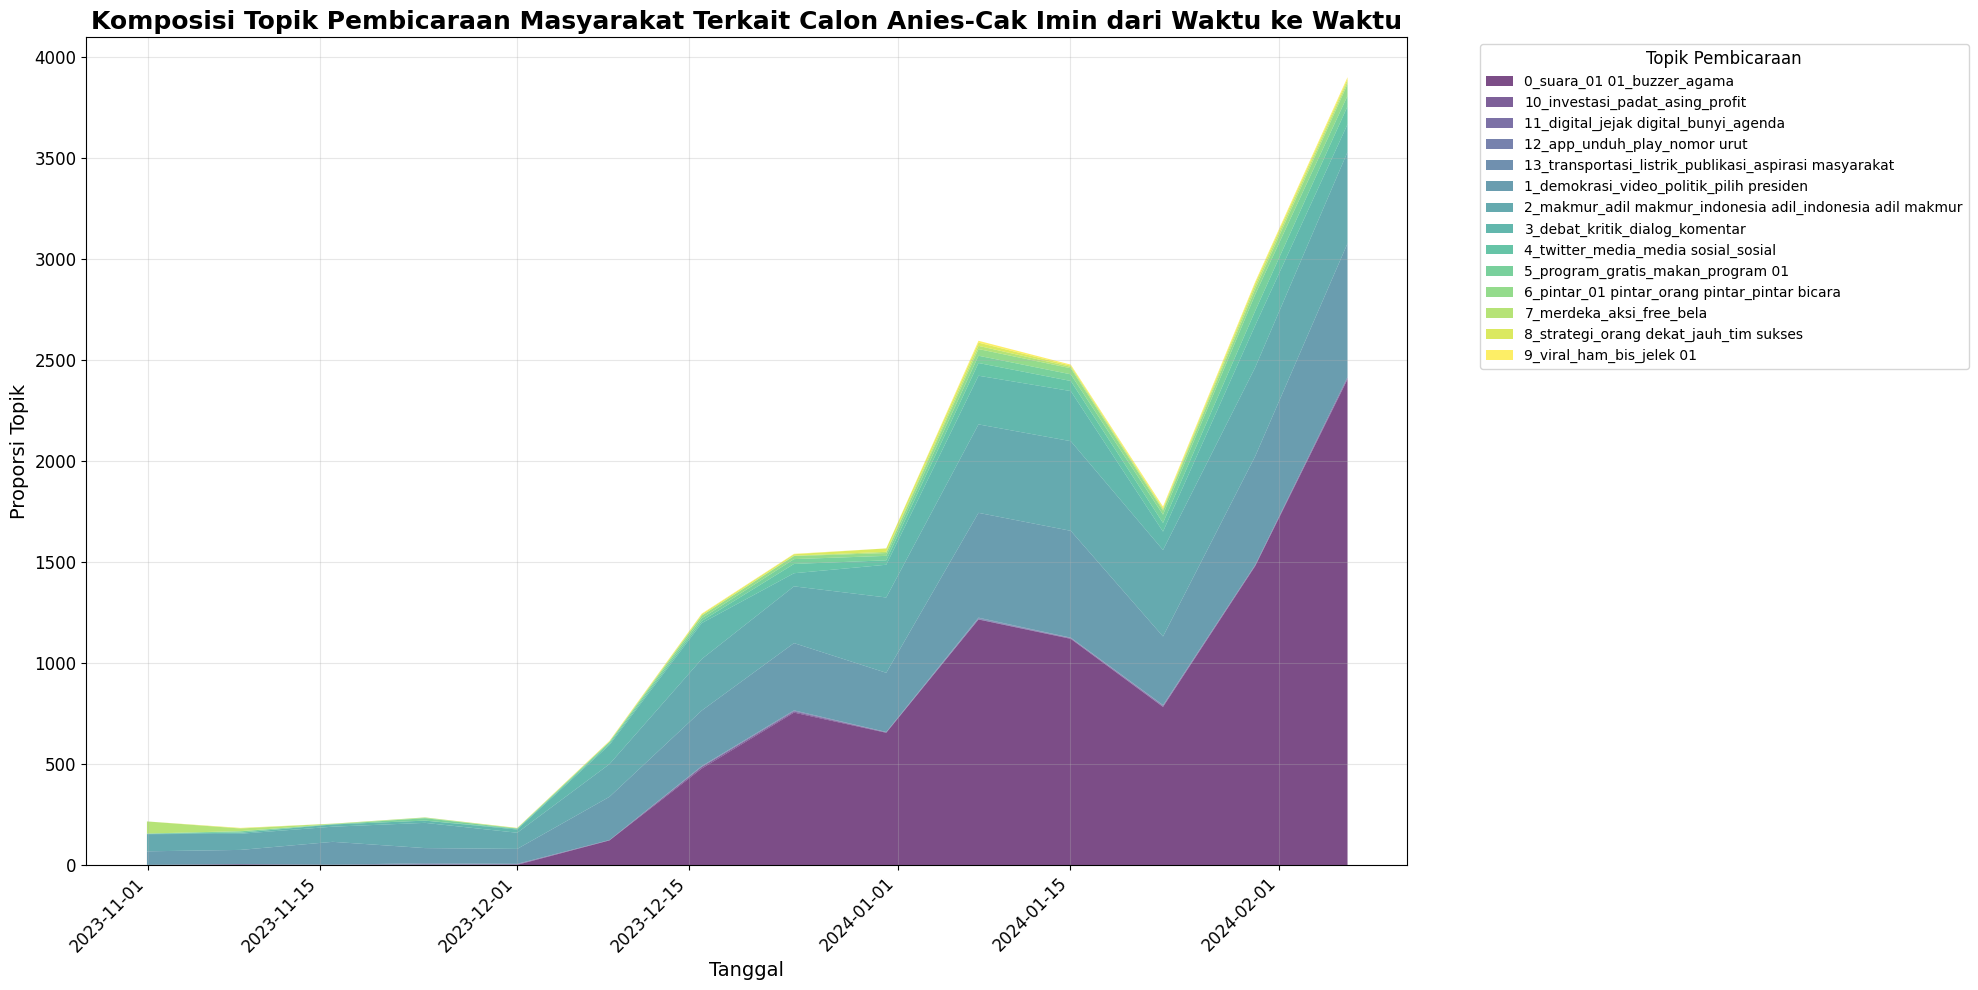

In [7]:
# Create a line plot showing topic prevalence over time
plt.figure(figsize=(20, 10))

# Get top topics excluding outliers
top_topics = [topic for topic in topic_model.get_topic_info()["Topic"][:8] if topic != -1]
topic_names = [topic_model.get_topic_info().loc[topic_model.get_topic_info()["Topic"] == topic, "Name"].values[0] 
               for topic in top_topics]

# Filter the topics_over_time DataFrame to include only top topics
filtered_tot = topics_over_time[topics_over_time["Topic"].isin(top_topics)]

# Create a pivot table for easier plotting
pivot_data = pd.pivot_table(
    data=filtered_tot,
    index="Timestamp", 
    columns="Name",
    values="Frequency",
    aggfunc="sum"
).fillna(0)

# Plot the data with a better style
ax = pivot_data.plot(kind='line', marker='o', markersize=8, figsize=(20, 10), linewidth=2.5)

# Format the plot
plt.title("Evolusi Topik Pembicaraan Masyarakat Terkait Calon Anies-Cak Imin (November 2023 - Februari 2024)", fontsize=18, fontweight='bold')
plt.xlabel("Tanggal", fontsize=14)
plt.ylabel("Frekuensi Topik", fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend(title="Topik Pembicaraan", fontsize=12, title_fontsize=14)
plt.tight_layout()

# Format date axis to be more readable
date_format = mdates.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_formatter(date_format)
plt.grid(True, linestyle='--', alpha=0.7)

# Add date markers for key events
key_events = {
    "2023-11-25": "Akhir Masa Pencalonan Presiden",
    "2023-11-28": "Awal Masa Kampanye",
    "2023-12-12": "Debat Pertama (Capres)",
    "2023-12-22": "Debat Kedua (Cawapres)",
    "2024-01-07": "Debat Ketiga (Capres)",
    "2024-01-21": "Debat Keempat (Cawapres)",
    "2024-02-04": "Debat Kelima (Capres)",
    "2024-02-10": "Akhir Masa Kampanye",
    "2024-02-14": "Pemungutan Suara"
}

# Add vertical lines for key events
for date_str, event_name in key_events.items():
    event_date = pd.to_datetime(date_str)
    if event_date >= pivot_data.index.min() and event_date <= pivot_data.index.max():
        plt.axvline(x=event_date, color='red', linestyle='--', alpha=0.7)
        plt.text(event_date, plt.ylim()[1]*0.95, event_name, rotation=90, 
                 verticalalignment='top', fontsize=12, fontweight='bold')

plt.show()

# Area chart showing the full topic composition over time
plt.figure(figsize=(20, 10))

# Create a stacked area chart
pivot_data_all = pd.pivot_table(
    data=topics_over_time[topics_over_time["Topic"] != -1],  # Exclude outliers
    index="Timestamp", 
    columns="Name",
    values="Frequency",
    aggfunc="sum"
).fillna(0)

# Plot as a stacked area chart
pivot_data_all.plot.area(figsize=(20, 10), alpha=0.7, linewidth=0, stacked=True, colormap='viridis')

# Format the plot
plt.title("Komposisi Topik Pembicaraan Masyarakat Terkait Calon Anies-Cak Imin dari Waktu ke Waktu", fontsize=18, fontweight='bold')
plt.xlabel("Tanggal", fontsize=14)
plt.ylabel("Proporsi Topik", fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend(title="Topik Pembicaraan", fontsize=10, title_fontsize=12, 
          bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

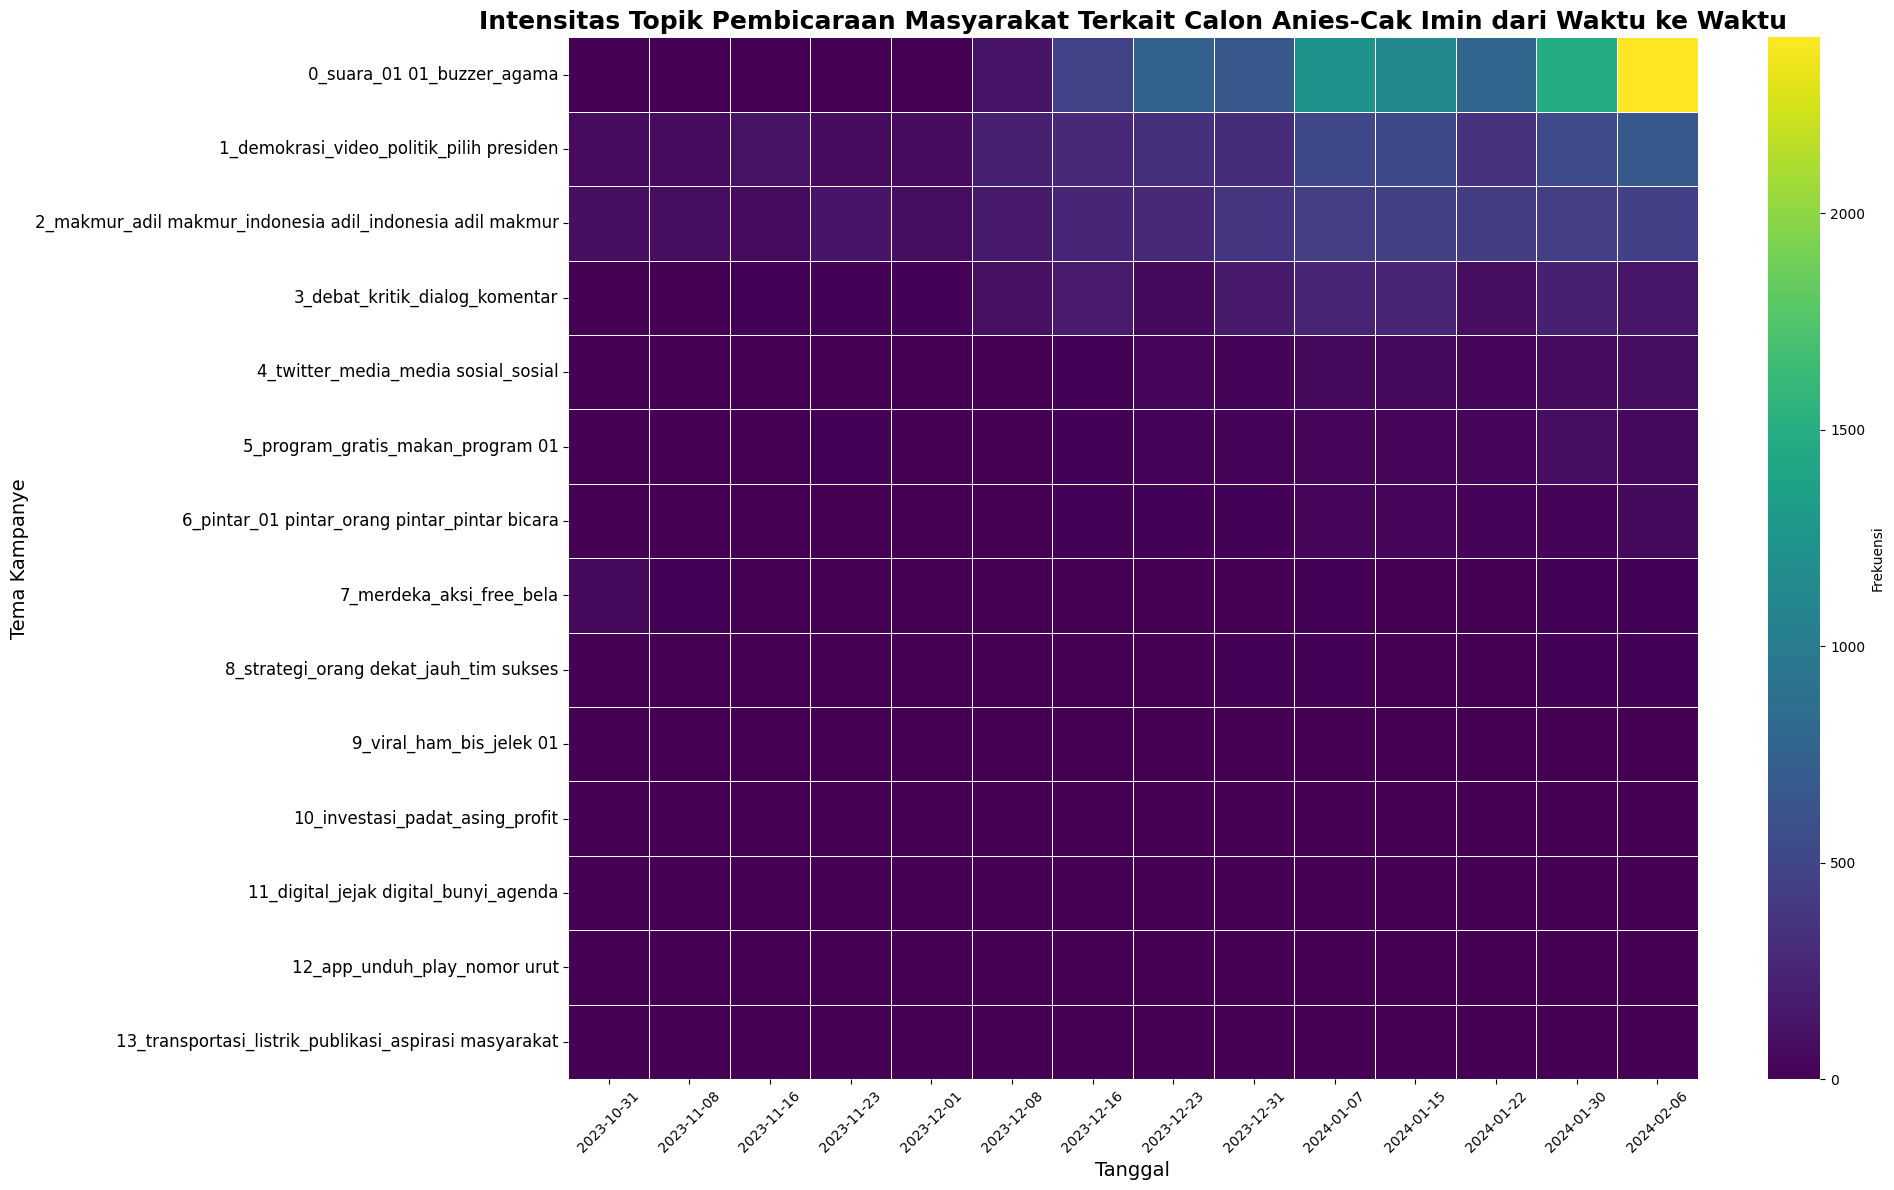

In [ ]:
# Create a heatmap for topics over time to easily view patterns
plt.figure(figsize=(20, 12))

# Create a pivot table for the heatmap
heatmap_data = pd.pivot_table(
    data=topics_over_time[topics_over_time["Topic"] != -1],  # Exclude outliers
    index="Name", 
    columns=pd.to_datetime(topics_over_time["Timestamp"]).dt.date,
    values="Frequency",
    aggfunc="sum"
).fillna(0)

# Sort topics by average frequency
heatmap_data = heatmap_data.loc[heatmap_data.mean(axis=1).sort_values(ascending=False).index]

# Create the heatmap
sns.heatmap(heatmap_data, cmap="viridis", annot=False, fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Frekuensi'})

# Format the plot
plt.title("Intensitas Topik Pembicaraan Masyarakat Terkait Calon Anies-Cak Imin dari Waktu ke Waktu", fontsize=18, fontweight='bold')
plt.xlabel("Tanggal", fontsize=14)
plt.ylabel("Topik Pembicaraan", fontsize=14)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Batches: 100%|██████████| 135/135 [00:53<00:00,  2.51it/s]
2025-05-24 19:57:49,436 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-05-24 19:58:02,513 - BERTopic - Dimensionality - Completed ✓
2025-05-24 19:58:02,514 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-05-24 19:58:02,751 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-05-24 19:59:08,151 - BERTopic - Probabilities - Completed ✓
2025-05-24 19:59:08,152 - BERTopic - Cluster - Completed ✓
Batches: 100%|██████████| 799/799 [04:34<00:00,  2.91it/s]
2025-05-24 20:03:42,983 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-05-24 20:03:51,777 - BERTopic - Dimensionality - Completed ✓
2025-05-24 20:03:51,778 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-05-24 20:03:53,550 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-05-24 20:10:43,952 - BERTopic

<Figure size 1500x1000 with 0 Axes>

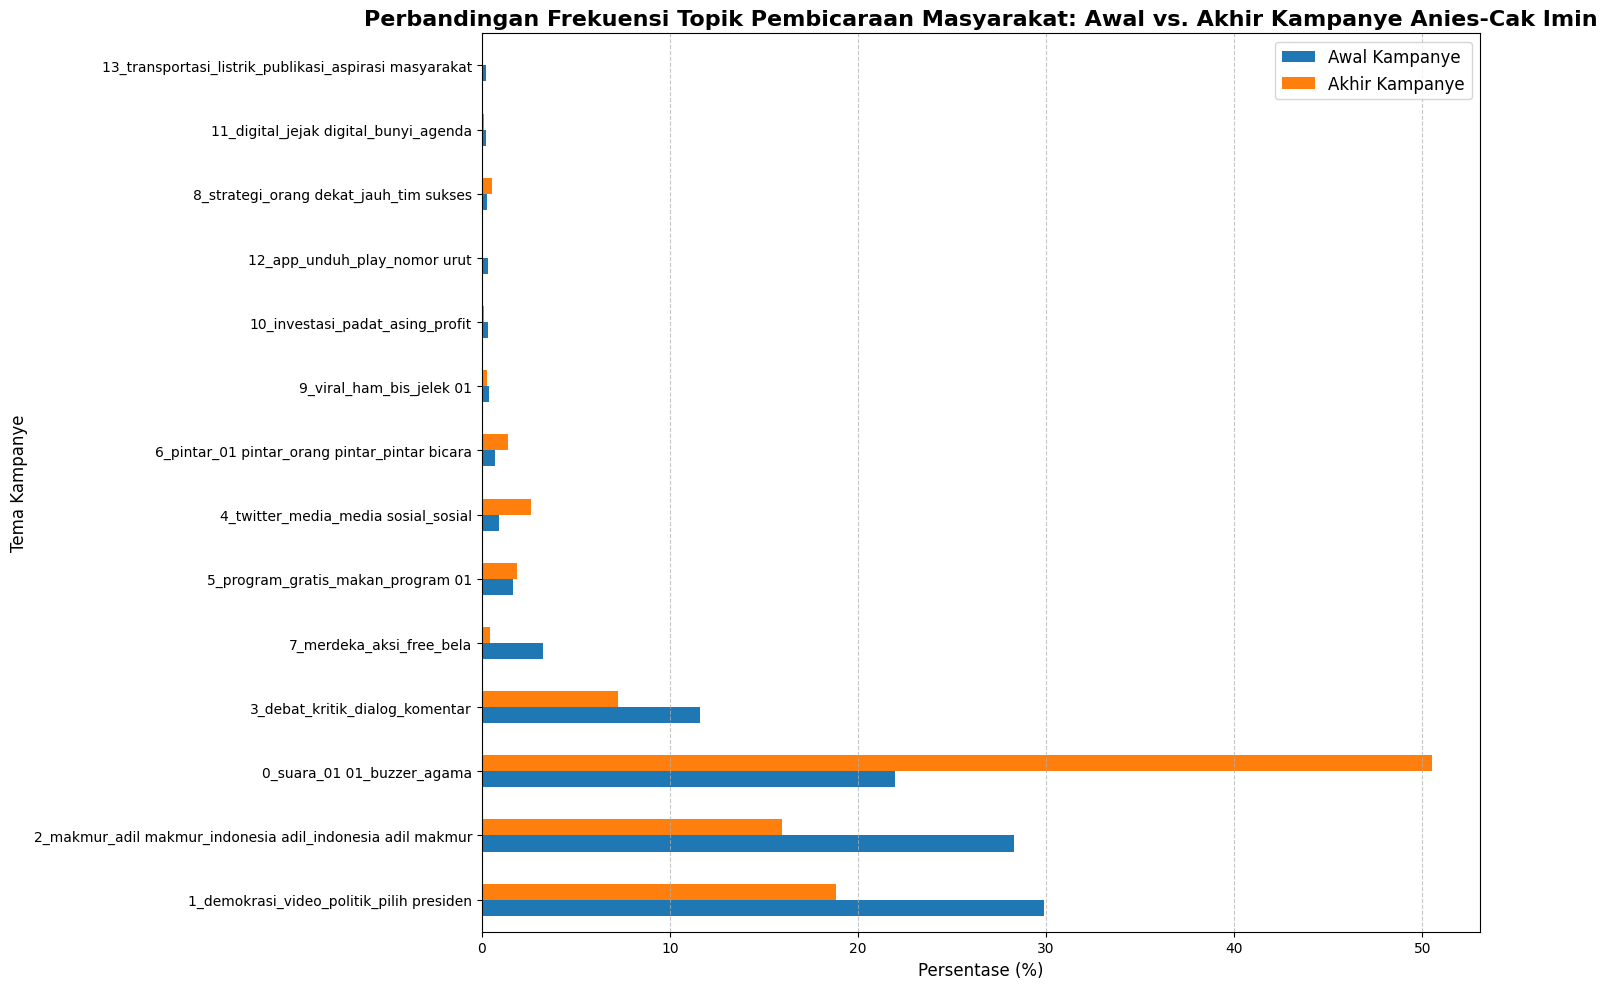


=== RINGKASAN ANALISIS TOPIK DARI WAKTU KE WAKTU ===

Periode Awal (2023-11-01 hingga 2023-12-23):


TypeError: 'zip' object is not subscriptable

In [9]:
# Divide the campaign period into early and late periods for comparison
mid_point = sorted(df_01['date'].unique())[len(sorted(df_01['date'].unique()))//2]
early_period = df_01[df_01['date'] < mid_point]
late_period = df_01[df_01['date'] >= mid_point]

# Get topic distributions for each period
early_topics, _ = topic_model.transform(early_period['full_text'].tolist())
late_topics, _ = topic_model.transform(late_period['full_text'].tolist())

# Calculate topic frequencies for each period (excluding outliers)
early_freq = pd.Series([t for t in early_topics if t != -1]).value_counts(normalize=True)
late_freq = pd.Series([t for t in late_topics if t != -1]).value_counts(normalize=True)

# Create a comparative visualization
plt.figure(figsize=(15, 10))

# Get all topics that appear in either period
all_topics = sorted(set(early_freq.index) | set(late_freq.index))
topic_labels_list = [topic_model.get_topic_info().loc[topic_model.get_topic_info()["Topic"] == t, "Name"].values[0] 
                for t in all_topics]

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Awal Kampanye': [early_freq.get(t, 0) * 100 for t in all_topics],
    'Akhir Kampanye': [late_freq.get(t, 0) * 100 for t in all_topics]
}, index=topic_labels_list)

# Sort by overall frequency
comparison_df = comparison_df.sort_values(by=['Awal Kampanye', 'Akhir Kampanye'], ascending=False)

# Create a horizontal bar chart
comparison_df.plot.barh(figsize=(15, 10))
plt.title('Perbandingan Frekuensi Topik Pembicaraan Masyarakat: Awal vs. Akhir Kampanye Anies-Cak Imin', fontsize=16, fontweight='bold')
plt.xlabel('Persentase (%)', fontsize=12)
plt.ylabel('Tema Kampanye', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Print summary findings
print("\n=== RINGKASAN ANALISIS TOPIK DARI WAKTU KE WAKTU ===\n")
print(f"Periode Awal ({early_period['date'].min()} hingga {early_period['date'].max()}):")
for topic, pct in early_freq.items()[:5]:
    topic_label = topic_model.get_topic_info().loc[topic_model.get_topic_info()["Topic"] == topic, "Name"].values[0]
    print(f"- {topic_label}: {pct*100:.1f}%")

print(f"\nPeriode Akhir ({late_period['date'].min()} hingga {late_period['date'].max()}):")
for topic, pct in late_freq.items()[:5]:
    topic_label = topic_model.get_topic_info().loc[topic_model.get_topic_info()["Topic"] == topic, "Name"].values[0]
    print(f"- {topic_label}: {pct*100:.1f}%")

Batches: 100%|██████████| 39/39 [00:22<00:00,  1.76it/s]
2025-05-24 20:21:56,282 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-05-24 20:21:56,893 - BERTopic - Dimensionality - Completed ✓
2025-05-24 20:21:56,894 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-05-24 20:21:56,967 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-05-24 20:22:14,171 - BERTopic - Probabilities - Completed ✓
2025-05-24 20:22:14,172 - BERTopic - Cluster - Completed ✓
Batches: 100%|██████████| 169/169 [00:59<00:00,  2.84it/s]
2025-05-24 20:23:13,694 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-05-24 20:23:15,933 - BERTopic - Dimensionality - Completed ✓
2025-05-24 20:23:15,934 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-05-24 20:23:16,258 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-05-24 20:24:42,415 - BERTopic -

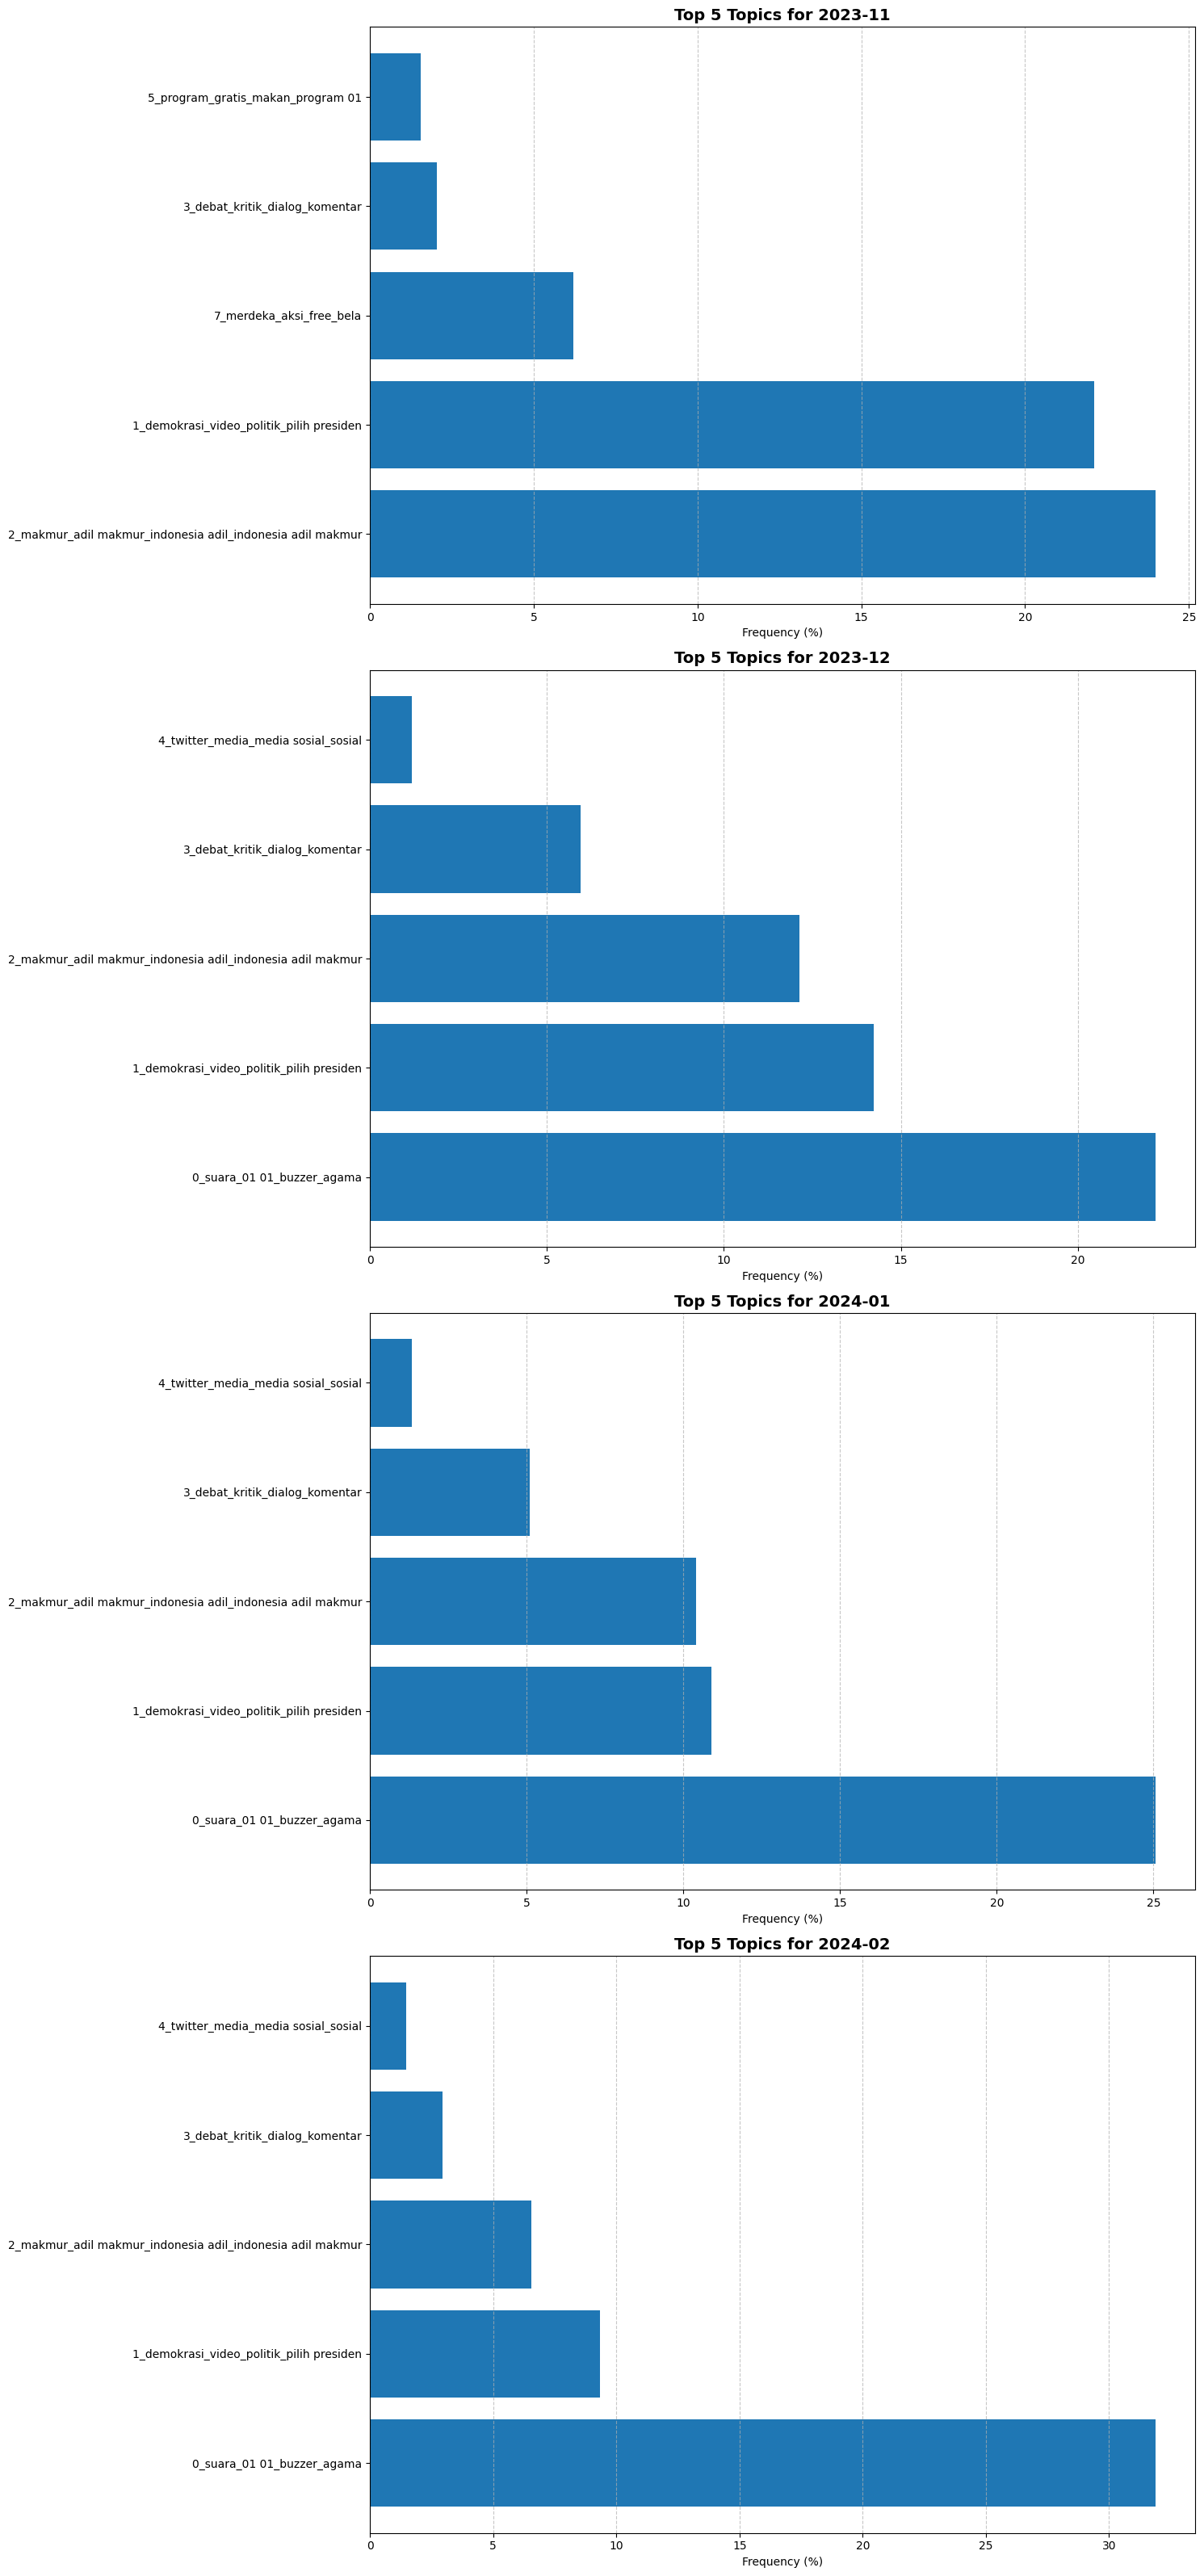


=== ANALISIS TOPIK PEMBICARAAN MASYARAKAT TERKAIT CALON ANIES-CAK IMIN ===


Bulan: 2023-11
--------------------------------------------------
1. 2_makmur_adil makmur_indonesia adil_indonesia adil makmur: 24.0%
2. 1_demokrasi_video_politik_pilih presiden: 22.1%
3. 7_merdeka_aksi_free_bela: 6.2%
4. 3_debat_kritik_dialog_komentar: 2.0%
5. 5_program_gratis_makan_program 01: 1.5%

Bulan: 2023-12
--------------------------------------------------
1. 0_suara_01 01_buzzer_agama: 22.2%
2. 1_demokrasi_video_politik_pilih presiden: 14.2%
3. 2_makmur_adil makmur_indonesia adil_indonesia adil makmur: 12.1%
4. 3_debat_kritik_dialog_komentar: 5.9%
5. 4_twitter_media_media sosial_sosial: 1.2%

Bulan: 2024-01
--------------------------------------------------
1. 0_suara_01 01_buzzer_agama: 25.1%
2. 1_demokrasi_video_politik_pilih presiden: 10.9%
3. 2_makmur_adil makmur_indonesia adil_indonesia adil makmur: 10.4%
4. 3_debat_kritik_dialog_komentar: 5.1%
5. 4_twitter_media_media sosial_sosial: 1.3%

Bul

In [10]:
# Add month column to the dataframe
df_01['month'] = df_01['created_at'].dt.to_period('M')

# Get unique months
months = sorted(df_01['month'].unique())

# Dictionary to store results
monthly_topics = {}

# Analyze topics for each month
for month in months:
    # Filter data for the month
    month_data = df_01[df_01['month'] == month]
    
    # Transform the texts for this month
    month_docs = month_data['full_text'].tolist()
    month_topics, _ = topic_model.transform(month_docs)
    
    # Get topic frequencies (excluding outliers)
    topic_freq = pd.Series([t for t in month_topics if t != -1]).value_counts()
    
    # Get top 5 topics
    top_5_topics = []
    for topic_id in topic_freq.head(5).index:
        topic_label = topic_model.get_topic_info().loc[
            topic_model.get_topic_info()["Topic"] == topic_id, "Name"].values[0]
        frequency = topic_freq[topic_id] / len(month_topics) * 100
        top_5_topics.append((topic_label, frequency))
    
    monthly_topics[month] = top_5_topics

# Visualize results
plt.figure(figsize=(15, 8 * len(months)))

for idx, (month, topics) in enumerate(monthly_topics.items()):
    plt.subplot(len(months), 1, idx + 1)
    
    topic_labels = [t[0] for t in topics]
    frequencies = [t[1] for t in topics]
    
    plt.barh(topic_labels, frequencies)
    plt.title(f'Top 5 Topics for {month}', fontsize=14, fontweight='bold')
    plt.xlabel('Frequency (%)')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
plt.tight_layout()
plt.show()

# Print detailed results
print("\n=== ANALISIS TOPIK PEMBICARAAN MASYARAKAT TERKAIT CALON ANIES-CAK IMIN ===\n")
for month, topics in monthly_topics.items():
    print(f"\nBulan: {month}")
    print("-" * 50)
    for idx, (topic, freq) in enumerate(topics, 1):
        print(f"{idx}. {topic}: {freq:.1f}%")